# Splitting

In [1]:
import pandas as pd

In [2]:
splits = pd.read_csv('../../vbd_vol/splits.csv')
splits['id'] = splits['Image_Index'].apply(lambda x : x.split(".")[0])
splits['png'] = splits['id'].apply(lambda x : x + ".png")
splits = splits.drop(columns=['Image_Index'])

splits

,set,id,png
0,TRAINING,97fd4f6e94b84fc564ae30aec660e443,97fd4f6e94b84fc564ae30aec660e443.png
1,TRAINING,37054193bd4e6a2f3ca764088913b0f0,37054193bd4e6a2f3ca764088913b0f0.png
2,TRAINING,62863bee894cbb15f96074e8da760b40,62863bee894cbb15f96074e8da760b40.png
3,TRAINING,89bab84561df6af7b88b6a7d05254725,89bab84561df6af7b88b6a7d05254725.png
4,TRAINING,3df005a70ab162381374fd43655aa145,3df005a70ab162381374fd43655aa145.png
...,...,...,...
4389,TEST,a8ae76a6902d594f90596f039ffca026,a8ae76a6902d594f90596f039ffca026.png
4390,TEST,382fde0b4f36b498850d79b00cf5593d,382fde0b4f36b498850d79b00cf5593d.png
4391,TEST,e282be557a81566f8ccc78271c7f2ff2,e282be557a81566f8ccc78271c7f2ff2.png
4392,TEST,53d4fbf11ca8be107a343df37ca9eddc,53d4fbf11ca8be107a343df37ca9eddc.png


In [3]:
png_set = set(splits['png'].values.tolist())

In [4]:
import os

pngs = os.listdir('../../vbd_vol/pngs_512/train/')
len(pngs)

15000

In [5]:
in_n_out = {'in': [], 'out': []}
for p in pngs:
    if p in png_set:
        in_n_out['in'].append(p)
    else:
        in_n_out['out'].append(p)

In [6]:
len(in_n_out['in']), len(in_n_out['out']), splits.shape[0]

(4394, 10606, 4394)

In [7]:
file_splits = {}
base_path = '../vbd_vol/pngs_512/train/'
for p in in_n_out['in']:
    prow = splits.query(f'png == "{p}"')
    prow = prow.values.flatten()
    if prow[0] not in file_splits:
        file_splits[prow[0]] = []
    file_splits[prow[0]].append(os.path.join(base_path, p))

In [8]:
[(k, len(v)) for k,v in file_splits.items()]

[('TRAINING', 2812), ('VALIDATION', 703), ('TEST', 879)]

In [9]:
splits.groupby('set').count()

,id,png
set,,
TEST,879,879
TRAINING,2812,2812
VALIDATION,703,703


In [78]:
from shutil import copyfile
from tqdm import tqdm

yolo_file_base = '../../vbd_vol/pngs_512/yolov5/images'
for k, v in file_splits.items():
    kpath = os.path.join(yolo_file_base, k)
    os.makedirs(kpath, exist_ok=True)
    
    print(f"Making {k} yolov5 folder...")
    for png in tqdm(v):
        name = os.path.basename(png)
        copyfile(png, os.path.join(kpath, name))

  2%|▏         | 60/2812 [00:00<00:04, 591.27it/s]

Making TRAINING yolov5 folder...


 11%|█         | 75/703 [00:00<00:00, 743.17it/s]

Making VALIDATION yolov5 folder...


  9%|▉         | 78/879 [00:00<00:01, 779.82it/s]

Making TEST yolov5 folder...


100%|██████████| 879/879 [00:01<00:00, 683.59it/s]


In [79]:
train_set = set(os.listdir('../../vbd_vol/pngs_512/yolov5/images/TRAINING/'))
valid_set = set(os.listdir('../../vbd_vol/pngs_512/yolov5/images/VALIDATION/'))
test_set = set(os.listdir('../../vbd_vol/pngs_512/yolov5/images/TEST/'))

### Sanity Checks

In [80]:
train_set.intersection(valid_set)

set()

In [81]:
train_set.intersection(test_set)

set()

In [82]:
valid_set.intersection(test_set)

set()

In [83]:
sets = {
    'TRAINING': train_set,
    'VALIDATION': valid_set,
    'TEST': test_set
}

num_missing = {
    k: 0 for k,v in sets.items()
}
for k, v in file_splits.items():
    for png in v:
        # assert png in sets[k], f"{k}: Missing: {png}"
        if os.path.basename(png) not in sets[k]:
            num_missing[k] += 1

In [84]:
num_missing

{'TRAINING': 0, 'VALIDATION': 0, 'TEST': 0}

# Labelling

In [17]:
labels = pd.read_csv('../../vbd_vol/train_orig.csv')
meta = pd.read_csv('../../vbd_vol/pngs_512/train_meta.csv')
labels.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [18]:
meta.head()

,image_id,dim0,dim1
0,4d390e07733ba06e5ff07412f09c0a92,3000,3000
1,289f69f6462af4933308c275d07060f0,3072,3072
2,68335ee73e67706aa59b8b55b54b11a4,2836,2336
3,7ecd6f67f649f26c05805c8359f9e528,2952,2744
4,2229148faa205e881cf0d932755c9e40,2880,2304


In [19]:
big_df = meta.merge(labels, on='image_id')
big_df.head()

,image_id,dim0,dim1,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,4d390e07733ba06e5ff07412f09c0a92,3000,3000,No finding,14,R1,NaN,NaN,NaN,NaN
1,4d390e07733ba06e5ff07412f09c0a92,3000,3000,No finding,14,R14,NaN,NaN,NaN,NaN
2,4d390e07733ba06e5ff07412f09c0a92,3000,3000,No finding,14,R12,NaN,NaN,NaN,NaN
3,289f69f6462af4933308c275d07060f0,3072,3072,No finding,14,R8,NaN,NaN,NaN,NaN
4,289f69f6462af4933308c275d07060f0,3072,3072,No finding,14,R9,NaN,NaN,NaN,NaN


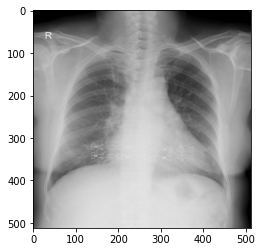

In [20]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open('../../vbd_vol/pngs_512/train/9a5094b2563a1ef3ff50dc5c7ff71345.png')
rgbimg = Image.new("RGB", img.size)
rgbimg.paste(img)
img_arr = np.asarray(rgbimg)
plt.imshow(img_arr)

In [21]:
height, width, channels = img_arr.shape
height, width, channels

(512, 512, 3)

In [22]:
# dim0 = original height, dim1 = original width

sample_labels = big_df.query(f'image_id == "9a5094b2563a1ef3ff50dc5c7ff71345"').copy(deep=True)
sample_labels

,image_id,dim0,dim1,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
63208,9a5094b2563a1ef3ff50dc5c7ff71345,2336,2080,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
63209,9a5094b2563a1ef3ff50dc5c7ff71345,2336,2080,Pleural effusion,10,R9,1789.0,1729.0,1875.0,1992.0
63210,9a5094b2563a1ef3ff50dc5c7ff71345,2336,2080,Pleural thickening,11,R9,1789.0,1729.0,1875.0,1992.0
63211,9a5094b2563a1ef3ff50dc5c7ff71345,2336,2080,Cardiomegaly,3,R9,692.0,1375.0,1657.0,1799.0
63212,9a5094b2563a1ef3ff50dc5c7ff71345,2336,2080,Cardiomegaly,3,R8,689.0,1313.0,1666.0,1763.0
63213,9a5094b2563a1ef3ff50dc5c7ff71345,2336,2080,Aortic enlargement,0,R9,1052.0,715.0,1299.0,966.0


In [23]:
sample_labels['y_minr'] = sample_labels['y_min'] * (height / sample_labels['dim0'])
sample_labels['x_minr'] = sample_labels['x_min'] * (width / sample_labels['dim1'])
sample_labels['y_maxr'] = sample_labels['y_max'] * (height / sample_labels['dim0'])
sample_labels['x_maxr'] = sample_labels['x_max'] * (width / sample_labels['dim1'])
sample_labels[['x_minr', 'y_minr', 'x_maxr', 'y_maxr']]

,x_minr,y_minr,x_maxr,y_maxr
63208,170.092308,301.369863,406.892308,401.315068
63209,440.369231,378.958904,461.538462,436.602740
63210,440.369231,378.958904,461.538462,436.602740
63211,170.338462,301.369863,407.876923,394.301370
63212,169.600000,287.780822,410.092308,386.410959
63213,258.953846,156.712329,319.753846,211.726027


In [24]:
import matplotlib.patches as patches

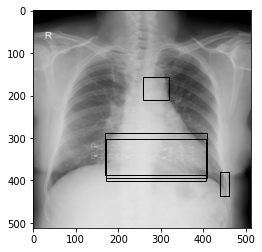

In [25]:
fig, ax = plt.subplots()

for index, row in sample_labels.iterrows():
    xmin, ymin = row['x_minr'], row['y_minr'], 
    h = row['y_maxr'] - row['y_minr']
    w = row['x_maxr'] - row['x_minr']
    rect = patches.Rectangle(
        (xmin, ymin), w, h, linewidth=1, fill=False
    )
    ax.add_patch(rect)
ax.imshow(img_arr)
plt.show()

### Applying Resizing BBOX to Bigger DF

In [26]:
sample_labels = big_df
sample_labels['y_minr'] = sample_labels['y_min'] * (height / sample_labels['dim0'])
sample_labels['x_minr'] = sample_labels['x_min'] * (width / sample_labels['dim1'])
sample_labels['y_maxr'] = sample_labels['y_max'] * (height / sample_labels['dim0'])
sample_labels['x_maxr'] = sample_labels['x_max'] * (width / sample_labels['dim1'])

In [27]:
sample_labels[['class_name', 'class_id', 'x_minr', 'y_minr', 'x_maxr', 'y_maxr']]

,class_name,class_id,x_minr,y_minr,x_maxr,y_maxr
0,No finding,14,NaN,NaN,NaN,NaN
1,No finding,14,NaN,NaN,NaN,NaN
2,No finding,14,NaN,NaN,NaN,NaN
3,No finding,14,NaN,NaN,NaN,NaN
4,No finding,14,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
67909,Aortic enlargement,0,283.833333,82.333333,347.500000,139.333333
67910,Cardiomegaly,3,228.666667,208.500000,408.666667,284.833333
67911,No finding,14,NaN,NaN,NaN,NaN
67912,No finding,14,NaN,NaN,NaN,NaN


In [36]:
from tqdm import tqdm

height, width = 512, 512

def agg_func(row):
    # print(row)
    x1, y1, x2, y2 = row['x_minr'], row['y_minr'], row['x_maxr'], row['y_maxr']
    w, h = x2 - x1, y2 - y1
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2
    return [row['class_id'], cx / width, cy / height, w / width, h / height]

id_groups = sample_labels.groupby('image_id')
yolo_bboxes = {
    k: {} for k,v in sets.items()
}
for image_id, id_group in tqdm(id_groups):
    found = False
    dataset = None
    for k, v in sets.items():
        found = found or image_id + '.png' in v
        if found:
            dataset = k
            break
    
    if not found: 
        continue
    
    bboxes = []
    for row_index, row in id_group.iterrows():
        bboxes.append(agg_func(row))
    yolo_bboxes[dataset][image_id] = bboxes

100%|██████████| 15000/15000 [00:04<00:00, 3320.67it/s]


In [38]:
len(yolo_bboxes), [(k, len(v)) for k,v in yolo_bboxes.items()]

(3, [('TRAINING', 2812), ('VALIDATION', 703), ('TEST', 879)])

In [40]:
yolo_bboxes['TRAINING']['0005e8e3701dfb1dd93d53e2ff537b6e']

[[7,
  0.3426106770833333,
  0.24007161458333331,
  0.09928385416666663,
  0.09798177083333334],
 [8,
  0.3465169270833333,
  0.23811848958333331,
  0.08626302083333337,
  0.10709635416666663],
 [6,
  0.3426106770833333,
  0.24007161458333331,
  0.09928385416666663,
  0.09798177083333334],
 [7,
  0.3430989583333333,
  0.23974609374999997,
  0.09700520833333337,
  0.09993489583333331],
 [4,
  0.3465169270833333,
  0.23811848958333331,
  0.08626302083333337,
  0.10709635416666663]]

In [71]:
def make_txt_label(example, path):
    lines = []
    for l in example:
        line = f"{l[0]: <2} {l[1]:.5f} {l[2]:.5f} {l[3]:.5f} {l[4]:.5f}"
        lines.append(line)
        
    base_name = os.path.basename(path)
    folder_path = path.replace(base_name, "")
    os.makedirs(folder_path, exist_ok=True)

    with open(path, 'w') as f:
        for i, l in enumerate(lines):
            if i + 1 == len(lines):
                f.write(l)
            else:
                f.write(l + '\n')

In [72]:
label_base = '../../vbd_vol/pngs_512/yolov5/labels'
for k, v in yolo_bboxes.items():
    kbase = os.path.join(label_base, k)
    for img_id, bboxes in tqdm(v.items()):
        txtbase = os.path.join(kbase, img_id + '.txt')
        make_txt_label(bboxes, txtbase)

100%|██████████| 879/879 [00:00<00:00, 2705.14it/s]


In [73]:
len(os.listdir('../../vbd_vol/pngs_512/yolov5/labels/TRAINING/'))

2812

In [75]:
len(os.listdir('../../vbd_vol/pngs_512/yolov5/labels/TEST/'))

879

In [77]:
len(os.listdir('../../vbd_vol/pngs_512/yolov5/labels/VALIDATION/'))

703

# Getting Label Map

In [92]:
ordered_classes = big_df[['class_name', 'class_id']]
ordered_classes = ordered_classes.drop_duplicates().sort_values('class_id')
ordered_classes = ordered_classes.reset_index(drop='index')
ordered_classes

,class_name,class_id
0,Aortic enlargement,0
1,Atelectasis,1
2,Calcification,2
3,Cardiomegaly,3
4,Consolidation,4
5,ILD,5
6,Infiltration,6
7,Lung Opacity,7
8,Nodule/Mass,8
9,Other lesion,9


In [97]:
classes = ordered_classes['class_name'].values.tolist()
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis',
 'No finding']

In [98]:
len(classes)

15